
# Biharmonic problem
.. index:: Equations; Biharmonic problems; interior penalty

.. sectionauthor:: contribution by Philip Herbert <P.Herbert@sussex.ac.uk>

We use Dune to solve a Bilaplace problem using the interior penalty method.

We are interested in the problem that
$u \in H^2_0(\Omega)$ satisfies
\begin{align*}
\Delta^2 u &= f  && \text{in } \Omega,\\
\partial_\nu u &= 0     && \text{on } \partial \Omega,\\
u &= 0     && \text{on } \partial \Omega.
\end{align*}
For some $f \in H^{-2}(\Omega)$.
This is known as the clamped bilaplace problem.
Other boundary conditions can be considered [todo].

One of the standard variational formulations for this problem is given as:
\begin{equation} \int_\Omega \Delta u \Delta v dx = \langle f, v \rangle \quad \forall v \in H^2_0(\Omega) \end{equation}
This of course uses $H^2_0(\Omega)$ for which we require more regularity than is admissible by standard Lagrange finite elements.
One approach to tackle this is to use $C^1$ conforming finite elements, however they are usually rather complicated.
An alternate approach is to use a mixed formulation, i.e., condsider an auxiliary variable $w$ such that $w = -\Delta u$, this also has its own drawbacks.
The appraoch we consider here is to use a non-conforming method, a $C^0$ conforming method nevertheless.
Since it is a non-conforming method, it has many similarities to a standard discontinuous Galerkin discretisation of a second order problem.

## Implementation
As standard, we begin by importing ufl.
In addition, we import alugrid and consider the domain $(0,1)^2$ and refine:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ufl import *
from dune.alugrid import aluSimplexGrid
vertices = np.array( [(0,0), (1,0), (1,1), (0,1),(0.5,0.5)] )
triangles = np.array( [(0,1,4), (1,2,4), (2,4,3), (3,4,0)] )
gridView = aluSimplexGrid({"vertices": vertices, "simplices": triangles})
gridView.hierarchicalGrid.globalRefine(2)

Introduce the space, test functions and the exact solution which we will estimate:

In [2]:
from dune.fem.space import lagrange
order = 2
space = lagrange(gridView, order=order)
u = TrialFunction(space)
v = TestFunction(space)
x = SpatialCoordinate(space)
exactFunction = sin(pi*x[0]) ** 2 * sin(pi*x[1])**2

We require that the order is 2 or greater.
This space is \emph{not} conforming.
As such, it is necessary to include some \emph{interior penalty} as well as terms which ensure consistency.
To begin with, one has the term which is standard from integration by parts in each element

In [3]:
laplace = lambda fn : div(grad(fn))
f = laplace(laplace(exactFunction))
a = laplace(u) * laplace(v)*dx - f*v * dx

Where we have set $f = \Delta^2 (\texttt{exactFunction})$
One also has the contribution due to integration by parts over the facets along with a symmetrisation term:

In [4]:
normal = FacetNormal(space)
a+= - avg(div(grad(u))) * jump(grad(v),normal) * dS
a+= - avg(div(grad(v))) * jump(grad(u),normal) * dS # a symmetrisation

a+= - div(grad(u)) * inner(grad(v),normal) * ds
a+= - div(grad(v)) * inner(grad(u),normal) * ds

As the the finite element functions are not $C^1$ from one triangle into the other, we penalise deviation from this

In [5]:
beta = 10 * order**2 / FacetArea(space)
a+= beta * inner(jump(grad(u),normal),jump(grad(v),normal))*dS

We have not yet taken account of the boundary conditions.
Since we are $C^0$ conforming, we may use DirichletBC to handle the Dirichlet aspect of the boundary, to handle the condition on the normal derivative, like in the interior, we penalise

In [6]:
from dune.ufl import DirichletBC
dbc = DirichletBC(space,exactFunction)
a+= beta * inner(grad(u-exactFunction),normal) * inner(grad(v),normal)*ds

We are now prepared to solve:

In [7]:
solution = space.function(name = "discrete_solution")

from scipy.sparse.linalg import spsolve
from dune.fem import assemble
aa, ff = assemble([a ==0, dbc])
solution.as_numpy[:] = spsolve( aa.as_numpy, ff.as_numpy )

Let us now run this a few times, observing convergence as the mesh gets smaller.
The appropriate way to measure the error of an IPC0 method is to use a mesh dependent norm, although one can also measure with standard $L^2$ and $H^1$ norms.

In [8]:
from dune.fem import integrate
from math import sqrt
dofs = [space.size]
errorL2 = [ sqrt(integrate((solution - exactFunction)**2, gridView, order = 2*order)) ]
errorH1 = [ sqrt(integrate(inner(grad( solution - exactFunction),grad( solution - exactFunction) ), gridView, order = 2*(order-1) ))]
errorH2 = [ sqrt(integrate(laplace(solution - exactFunction)**2, gridView, order = 2*(order-1)) + sum(assemble(jump(grad(solution),normal)**2*avg(v)*dS).as_numpy ) + sum(assemble(inner(grad(solution),normal)**2*v*ds).as_numpy )) ] # need to get the error

maxRefs = 4
for _ in range(maxRefs):
    gridView.hierarchicalGrid.globalRefine()
    aa, ff = assemble([a ==0, dbc])
    solution.as_numpy[:] = spsolve( aa.as_numpy, ff.as_numpy )
    dofs.append(space.size)
    errorL2.append( sqrt(integrate((solution - exactFunction)**2, gridView, order = 2*order) ))
    errorH1.append( sqrt(integrate(inner(grad( solution - exactFunction),grad( solution - exactFunction) ), gridView, order = 2*(order-1) )) )
    errorH2.append( sqrt(integrate(laplace(solution - exactFunction)**2, gridView, order = 2*(order-1)) + sum(assemble(jump(grad(solution),normal)**2*avg(v)*dS).as_numpy ) + sum(assemble(inner(grad(solution),normal)**2*v*ds).as_numpy ) ))

for i in range(len(dofs)):
    print(dofs[i], "\t", errorL2[i], "\t", errorH1[i], "\t", errorH2[i])

145 	 0.11364435987379069 	 0.6208740665237933 	 5.524365118462774
545 	 0.040222736062334494 	 0.23163339565450566 	 2.6399394758506594
2113 	 0.011783142261081804 	 0.0704921761187458 	 1.1694802938500162
8321 	 0.0031289044518890926 	 0.019059972164449168 	 0.537219805687854
33025 	 0.0007995694248290015 	 0.004898762462815688 	 0.2595946598097056


We may now plot this into graphs.

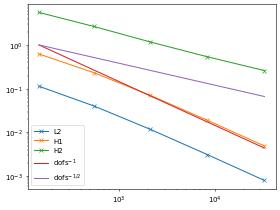

In [9]:

#sort out the graphs
plt.plot( dofs, errorL2, label = "L2", marker = 'x' )
plt.plot( dofs, errorH1, label = "H1", marker = 'x' )
plt.plot( dofs, errorH2, label = "H2", marker = 'x' )
plt.plot( dofs, [(d/dofs[0])**(-1) for d in dofs], label = r"dofs$^{-1}$")
plt.plot( dofs, [(d/dofs[0])**(-1/2) for d in dofs], label = r"dofs$^{-1/2}$")
plt.legend()
plt.loglog();

## Simply supported boundary conditions
In essence, very little changes here, we instead solve the problem
$u \in H^2(\Omega) \cap H^1_0(\Omega)$ such that
\begin{align*}
\Delta^2 u &= f  && \text{in } \Omega,\\
\Delta u &= 0     && \text{on } \partial \Omega,\\
u &= 0     && \text{on } \partial \Omega.
\end{align*}
The main difference is the integration along the boundary terms -
one no longer penalises the normal at the boundary, nor integrates
the consistency terms there.
Let us begin by resetting the grid to not be too refined.
We also change the exact/manufactured solution to match up to the boundary conditions

In [10]:
gridView.hierarchicalGrid.globalRefine(-maxRefs)

exactFunction = sin(pi*x[0]) * sin(pi*x[1])
f = laplace(laplace(exactFunction))

a = laplace(u) * laplace(v)*dx - f*v * dx
a+= - avg(div(grad(u))) * jump(grad(v),normal) * dS
a+= - avg(div(grad(v))) * jump(grad(u),normal) * dS

beta = 10 * order**2 / FacetArea(space)
a+= beta * inner(jump(grad(u),normal),jump(grad(v),normal))*dS

aa, ff = assemble([a ==0, dbc])
solution.as_numpy[:] = spsolve( aa.as_numpy, ff.as_numpy )

dofs = [space.size]
errorL2 = [ sqrt(integrate((solution - exactFunction)**2, gridView, order = 2*order)) ]
errorH1 = [ sqrt(integrate(inner(grad( solution - exactFunction),grad( solution - exactFunction) ), gridView, order = 2*(order-1) ))]
errorH2 = [ sqrt(integrate(laplace(solution - exactFunction)**2, gridView, order = 2*(order-1)) + sum(assemble(jump(grad(solution),normal)**2*avg(v)*dS).as_numpy ) ) ]

for _ in range(maxRefs):
    gridView.hierarchicalGrid.globalRefine()
    aa, ff = assemble([a ==0, dbc])
    solution.as_numpy[:] = spsolve( aa.as_numpy, ff.as_numpy )
    dofs.append(space.size)
    errorL2.append( sqrt(integrate((solution - exactFunction)**2, gridView, order = 2*order) ))
    errorH1.append( sqrt(integrate(inner(grad( solution - exactFunction),grad( solution - exactFunction) ), gridView, order = 2*(order-1) )) )
    errorH2.append( sqrt(integrate(laplace(solution - exactFunction)**2, gridView, order = 2*(order-1)) + sum(assemble(jump(grad(solution),normal)**2*avg(v)*dS).as_numpy ) ))

for i in range(len(dofs)):
    print(dofs[i], "\t", errorL2[i], "\t", errorH1[i], "\t", errorH2[i])

145 	 0.024862701102879293 	 0.11397097581491815 	 2.197431986473758
545 	 0.006358306803225917 	 0.029212936985119335 	 1.111869433533039
2113 	 0.0016038793619311507 	 0.007404936721736835 	 0.5581151873194751
8321 	 0.00040238765461926557 	 0.0018636846500255507 	 0.27943955725260217
33025 	 0.00010076401917758912 	 0.00046734009830973314 	 0.1397942710397


We may now plot this into graphs.

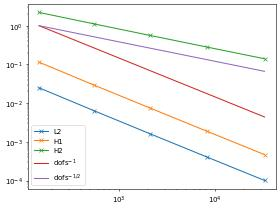

In [11]:

#sort out the graphs
plt.plot( dofs, errorL2, label = "L2", marker = 'x' )
plt.plot( dofs, errorH1, label = "H1", marker = 'x' )
plt.plot( dofs, errorH2, label = "H2", marker = 'x' )
plt.plot( dofs, [(d/dofs[0])**(-1) for d in dofs], label = r"dofs$^{-1}$")
plt.plot( dofs, [(d/dofs[0])**(-1/2) for d in dofs], label = r"dofs$^{-1/2}$")
plt.legend()
plt.loglog();